In [1]:
import os
import sys
import random
import joblib

import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd
import dotenv
import mlflow
from huggingface_hub import login

from pmdarima import auto_arima
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import StandardScaler

# random_seed = 42
random_seed = 42 * 2

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
sklearn.utils.check_random_state(random_seed)

sys.path.append("../..")

from utils import get_quantile_from_median, calculate_sklearn_metrics
from utils.plotting import plot_forecasts_val_test

dotenv.load_dotenv("../../.env")

token = os.environ["HF_TOKEN"]
login(token=token)

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("rosstat_forecasting");

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
data_dir = '../../../data/rosstat/processed'

train_df = pd.read_csv(os.path.join(data_dir, 'train/data.csv'))
val_df = pd.read_csv(os.path.join(data_dir, 'val/data.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test/data.csv'))

print(f"Обучающая выборка: {train_df.shape[0]} строк")
print(f"Валидационная выборка: {val_df.shape[0]} строк")
print(f"Тестовая выборка: {test_df.shape[0]} строк")

train_df_ = train_df[train_df['code'].eq(1)].drop(columns=['code', 'date']).reset_index(drop=True)
val_df_ = val_df[val_df['code'].eq(1)].drop(columns=['code', 'date']).reset_index(drop=True)
test_df_ = test_df[test_df['code'].eq(1)].drop(columns=['code', 'date']).reset_index(drop=True)

Обучающая выборка: 4140 строк
Валидационная выборка: 828 строк
Тестовая выборка: 828 строк


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1085.056, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1084.044, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1078.575, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1079.479, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1083.524, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1080.481, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1080.423, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1082.458, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1079.651, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.126 seconds


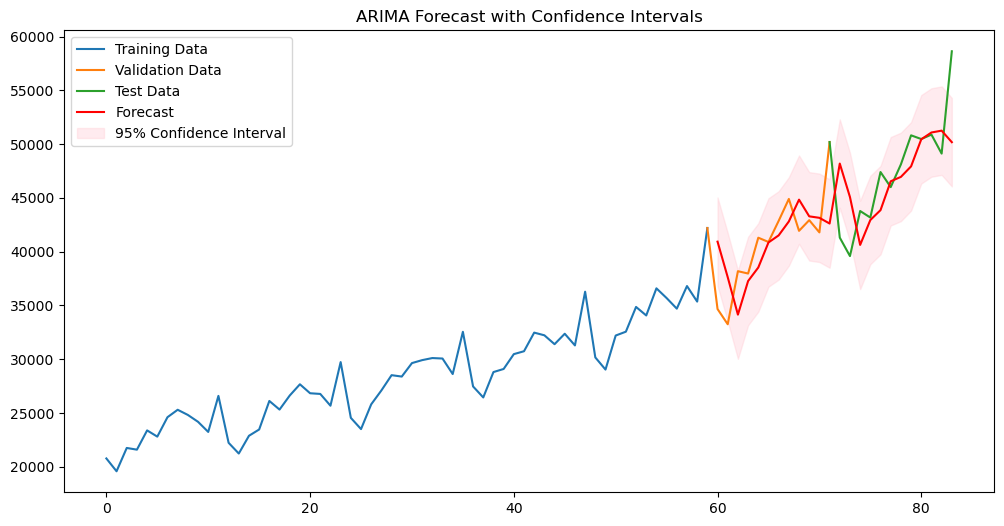

In [3]:
model = auto_arima(
    train_df_['nominal_wage'],
    trace=True,
    error_action="ignore",
    suppress_warnings=True)

one_step_predictions = []
lower_bounds = []
upper_bounds = []

for i in range(len(val_df_)):
    pred, conf_int = model.predict(n_periods=1, return_conf_int=True, alpha=0.05)

    one_step_predictions.append(pred.item())
    lower_bounds.append(conf_int[0, 0])
    upper_bounds.append(conf_int[0, 1])
    
    model.update(val_df_['nominal_wage'].iloc[i])

for i in range(len(test_df_)):
    pred, conf_int = model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
    
    one_step_predictions.append(pred.item())
    lower_bounds.append(conf_int[0, 0])
    upper_bounds.append(conf_int[0, 1])
    
    model.update(test_df_['nominal_wage'].iloc[i])

plt.figure(figsize=(12, 6))
old_temp_index = 0
temp_index = len(train_df_)
plt.plot(np.arange(0, temp_index), train_df_["nominal_wage"], label="Training Data")

old_temp_index = temp_index
temp_index += len(val_df_)
plt.plot(
    np.arange(old_temp_index - 1, temp_index),
    np.concatenate([np.array([train_df_["nominal_wage"].iloc[-1]]), val_df_["nominal_wage"].values]),
    label="Validation Data",
)

old_temp_index = temp_index
temp_index += len(test_df_)
plt.plot(
    np.arange(old_temp_index - 1, temp_index),
    np.concatenate([np.array([val_df_["nominal_wage"].iloc[-1]]), test_df_["nominal_wage"].values]),
    label="Test Data",
)

forecast_range = np.arange(len(train_df_), len(train_df_) + len(one_step_predictions))
plt.plot(forecast_range, one_step_predictions, label="Forecast", color='red')

plt.fill_between(
    forecast_range,
    lower_bounds,
    upper_bounds,
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.legend()
plt.title('ARIMA Forecast with Confidence Intervals')
plt.show()

In [4]:
unique_codes = train_df['code'].unique()

val_results = {
   'code': [],
   'date': [],
   'lower': [],
   'pred': [],
   'upper': []
}

test_results = {
   'code': [],
   'date': [],
   'lower': [],
   'pred': [],
   'upper': []
}

for code in tqdm(unique_codes):
   train_df_ = train_df[train_df['code'].eq(code)].reset_index(drop=True)
   val_df_ = val_df[val_df['code'].eq(code)].reset_index(drop=True)
   test_df_ = test_df[test_df['code'].eq(code)].reset_index(drop=True)
   
   val_dates = val_df_['date'].tolist()
   test_dates = test_df_['date'].tolist()
   
   train_df_ = train_df_.drop(columns=['code', 'date']).reset_index(drop=True)
   val_df_ = val_df_.drop(columns=['code', 'date']).reset_index(drop=True)
   test_df_ = test_df_.drop(columns=['code', 'date']).reset_index(drop=True)
   
   model = auto_arima(
       train_df_['nominal_wage'],
       trace=False,
       error_action="ignore",
       suppress_warnings=True)
   
   val_predictions = []
   val_lower_bounds = []
   val_upper_bounds = []
   
   for i in range(len(val_df_)):
       pred, conf_int = model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
       val_predictions.append(pred.item())
       val_lower_bounds.append(conf_int[0, 0])
       val_upper_bounds.append(conf_int[0, 1])
       model.update(val_df_['nominal_wage'].iloc[i])
   
   test_predictions = []
   test_lower_bounds = []
   test_upper_bounds = []
   
   for i in range(len(test_df_)):
       pred, conf_int = model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
       test_predictions.append(pred.item())
       test_lower_bounds.append(conf_int[0, 0])
       test_upper_bounds.append(conf_int[0, 1])
       model.update(test_df_['nominal_wage'].iloc[i])
   
   val_results['code'].extend([code] * len(val_dates))
   val_results['date'].extend(val_dates)
   val_results['lower'].extend(val_lower_bounds)
   val_results['pred'].extend(val_predictions)
   val_results['upper'].extend(val_upper_bounds)
   
   test_results['code'].extend([code] * len(test_dates))
   test_results['date'].extend(test_dates)
   test_results['lower'].extend(test_lower_bounds)
   test_results['pred'].extend(test_predictions)
   test_results['upper'].extend(test_upper_bounds)

val_results_df = pd.DataFrame(val_results)
test_results_df = pd.DataFrame(test_results)

  0%|          | 0/69 [00:00<?, ?it/s]

In [5]:
val_results_df["y_true"] = val_df["nominal_wage"]
test_results_df["y_true"] = test_df["nominal_wage"]

model_name = "Auto Arima"
val_predictions = {
    model_name: val_results_df.drop(columns=["date"])
    .rename(
        columns={
            "pred": "mean",
            "lower": "0.1",
            "upper": "0.9",
        }
    )
    .set_index("code")
}

test_predictions = {
    model_name: test_results_df.drop(columns=["date"])
    .rename(
        columns={
            "pred": "mean",
            "lower": "0.1",
            "upper": "0.9",
        }
    )
    .set_index("code")
}

In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
from utils.plotting import plot_forecasts_val_test


date_col = pd.to_datetime(test_df["date"])
min_date = date_col.min().date()
max_date = date_col.max().date()
size_multiplyer = 2
height = 400 * size_multiplyer
width = 800 * size_multiplyer
item_id = 1
title = f'Предсказания номинальной заработной платы (для code = {item_id})'

start_date_picker = widgets.DatePicker(
    description="Start date:", disabled=False, value=min_date
)

end_date_picker = widgets.DatePicker(
    description="End date:", disabled=False, value=max_date
)

output_area = widgets.Output()


def on_button_clicked(b):
    with output_area:
        clear_output(wait=True)
        start_date = datetime.datetime.combine(
            start_date_picker.value, datetime.datetime.min.time()
        )
        end_date = datetime.datetime.combine(
            end_date_picker.value, datetime.datetime.min.time()
        )
        plot_forecasts_val_test(
            val_df=val_df_,
            test_df=test_df_,
            val_predictions=all_val_models_predictions_,
            test_predictions=test_predictions,
            title=title,
            start_date=start_date,
            end_date=end_date,
            height=height,
            width=width,
            item_id=item_id,
        )


plot_button = widgets.Button(description="Plot Forecasts")
plot_button.on_click(on_button_clicked)

controls = widgets.VBox(
    [widgets.HBox([start_date_picker, end_date_picker]), plot_button]
)

display(controls, output_area)

val_df_ = val_df.rename(columns={'date': 'timestamp', "nominal_wage": "target"})[['code', 'timestamp', "target"]]
val_df_ = val_df_[val_df_['code'].eq(item_id)].reset_index(drop=True)
val_df_['timestamp'] = pd.to_datetime(val_df_['timestamp'])

test_df_ = test_df.rename(columns={'date': 'timestamp', "nominal_wage": "target"})[['code', 'timestamp', "target"]]
test_df_ = test_df_[test_df_['code'].eq(item_id)].reset_index(drop=True)
test_df_['timestamp'] = pd.to_datetime(test_df_['timestamp'])

val_df_ = pd.concat([val_df_, test_df_.iloc[[0]]])

all_val_models_predictions_ = val_predictions.copy()
for model_ in all_val_models_predictions_.keys():
    all_val_models_predictions_[model_] = pd.concat([all_val_models_predictions_[model_], test_predictions[model_].loc[[item_id]].iloc[[0]]])

with output_area:
    plot_forecasts_val_test(
        val_df=val_df_,
        test_df=test_df_,
        val_predictions=all_val_models_predictions_,
        test_predictions=test_predictions,
        title=title,
        height=height,
        width=width,
        item_id=item_id,
    )

Output()

In [7]:
1/0

ZeroDivisionError: division by zero

In [ ]:
all_codes = train_df['code'].unique()

all_models_metrics = {}

for model_name in test_predictions.keys():
    metrics_df = []
    for code in all_codes:
        pred_df = pd.concat([
            test_predictions[model_name].rename(columns={'mean': '0.5'})
            .loc[code][["0.1", "0.5", "0.9"]]
            .reset_index(drop=True),
            test_df[test_df["code"].eq(code)][["nominal_wage"]].reset_index(drop=True),
        ], axis=1)
        pred_df = pd.DataFrame(pred_df)

        metrics_df.append(calculate_sklearn_metrics(pred_df, target_column='nominal_wage'))

    metrics_dict = pd.DataFrame(metrics_df).mean().to_dict()

    all_models_metrics[model_name] = metrics_dict

all_models_metrics

{'auto_arima': {'MSE': 126813889.2400233,
  'MAE': 5855.8483630242035,
  'MAPE': 6.265998763140668,
  'MASE': 5.364375479677657,
  'SQL': 2228.0401868450067}}

In [ ]:
prefix = model_name

for k, metrics_ in all_models_metrics.items():
    run_name = f"{k}_{prefix}"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_metrics(metrics_)
        mlflow.log_param("model_name", k)

        mlflow.set_tag("prefix", prefix)

🏃 View run auto_arima_auto_arima at: http://127.0.0.1:5000/#/experiments/169882278836627198/runs/8a35bbb8121b423f9815ddb42d1028b7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/169882278836627198
